# Tesseract OCR to convert Scanned Images to Text

- __Google OCR data sources:__ https://code.google.com/archive/p/isri-ocr-evaluation-tools/downloads
- __Google Report data:__ https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/isri-ocr-evaluation-tools/rep.3B.tar.gz
- __Data Structure Explanation:__ https://stackoverflow.com/questions/41181742/resources-containing-ocr-benchmark-test-sets-for-free
At the datasets link, you'll find a number of gziped tarballs you can download. In each tarball is a number of directories with a set of files. Each document has 3 files:

 - tif binary image file
 - txt text file
 - uzn zone file for describing the scanned image

- __Linux command to extract tar.gz files:__ https://www.interserver.net/tips/kb/extract-tar-gz-files-using-linux-command-line/ (`tar -xf rep.3B.tar.gz`)
- __Tesseract config:__ https://www.analyticsvidhya.com/blog/2020/05/build-your-own-ocr-google-tesseract-opencv/

### 1. Import packages and  Download data

In [41]:
from PIL import Image as Img
import pytesseract
#Tesseract 5.0.0
pytesseract.pytesseract.tesseract_cmd = 'C:/Users/plr7443/AppData/Local/Tesseract-OCR/tesseract.exe' 
from IPython.display import display, Image
import subprocess
import pandas as pd
import numpy as np
from collections import Counter
import os
import time
import warnings
warnings.filterwarnings('ignore')

### 2. Define utility functions

In [55]:
def walk_dir(directory):
    "Go inside one directory to read all files under direct folder and any sub-folders"
    try: 
        #Get all files and sub directory (folder) under a directory (ignore hidden files starting with '.')
        all_files = [directory +'/'+file for file in os.listdir(directory) if file[0] != '.'] 
    except:
        all_files = []
    # Extract direct files: direct files = files with extension like .txt, .csv, .xlsx, .ipynb that should have '.'
    direct_files = [file for file in all_files if (file[-6] == '.' or file[-5] == '.' or file[-4] == '.') 
                    and '/' not in file[-6:]] 
    #Get sub directories
    sub_dirs = set(all_files) - set(direct_files)
    
    if len(all_files) > len(direct_files): #Sub directory exists
        for subdir in sub_dirs:
            subfiles = walk_dir(subdir) #recursive run to get direct files under each sub directory
            direct_files += subfiles
    return direct_files

#Define display function
display_image = lambda img_path: display(Img.open(img_path)) #Img = PIL.Image

def tesseract_text(file_path):
    im = Img.open(file_path)
    im.save(file_path[:-3]+'png') #save .tif file to .png file
    img = Img.open(file_path[:-3]+'png')
    text = pytesseract.image_to_string(img,lang = 'eng') #use default config, customized config in 2 lines below
    #config = ('-l eng --oem 1 --psm 3')
    #text = pytesseract.image_to_string(img,config = config)
    os.remove(file_path[:-3]+'png') #remove extra file after reading text
    return text

def get_text_file(file_path):
    with open(file_path, mode = 'r') as f:
        content = f.read()
    return content
    

### 3. Convert Pictures to text with Tesseract OCR

#### 3.1. Explore Input Data

In [33]:
all_files = walk_dir(os.getcwd().replace('\\','/')+'/rep.3B')
picture_files = sorted([x for x in all_files if x[-4:] == '.tif'])
text_files = sorted([x for x in all_files if x[-4:] == '.txt'])
if len(picture_files) == len(text_files):
    print('There are {} files of each type (image/text)'.format(len(picture_files)))

There are 300 files of each type (image/text)


In [34]:
print('Picture files:')
print('\n'.join(picture_files[:3]))
print('\nText files:')
print('\n'.join(text_files[:3]))

Picture files:
C:/1.Quyen_all/Git_quyentn/Quyen_learning_repository/rep.3B/0/9500_002.3B.tif
C:/1.Quyen_all/Git_quyentn/Quyen_learning_repository/rep.3B/0/9500_010.3B.tif
C:/1.Quyen_all/Git_quyentn/Quyen_learning_repository/rep.3B/0/9500_023.3B.tif

Text files:
C:/1.Quyen_all/Git_quyentn/Quyen_learning_repository/rep.3B/0/9500_002.3B.txt
C:/1.Quyen_all/Git_quyentn/Quyen_learning_repository/rep.3B/0/9500_010.3B.txt
C:/1.Quyen_all/Git_quyentn/Quyen_learning_repository/rep.3B/0/9500_023.3B.txt


#### 3.2. Display a few picture from Google public Report data

1 C:/1.Quyen_all/Git_quyentn/Quyen_learning_repository/rep.3B/0/9500_010.3B.tif --------------------------------------------------


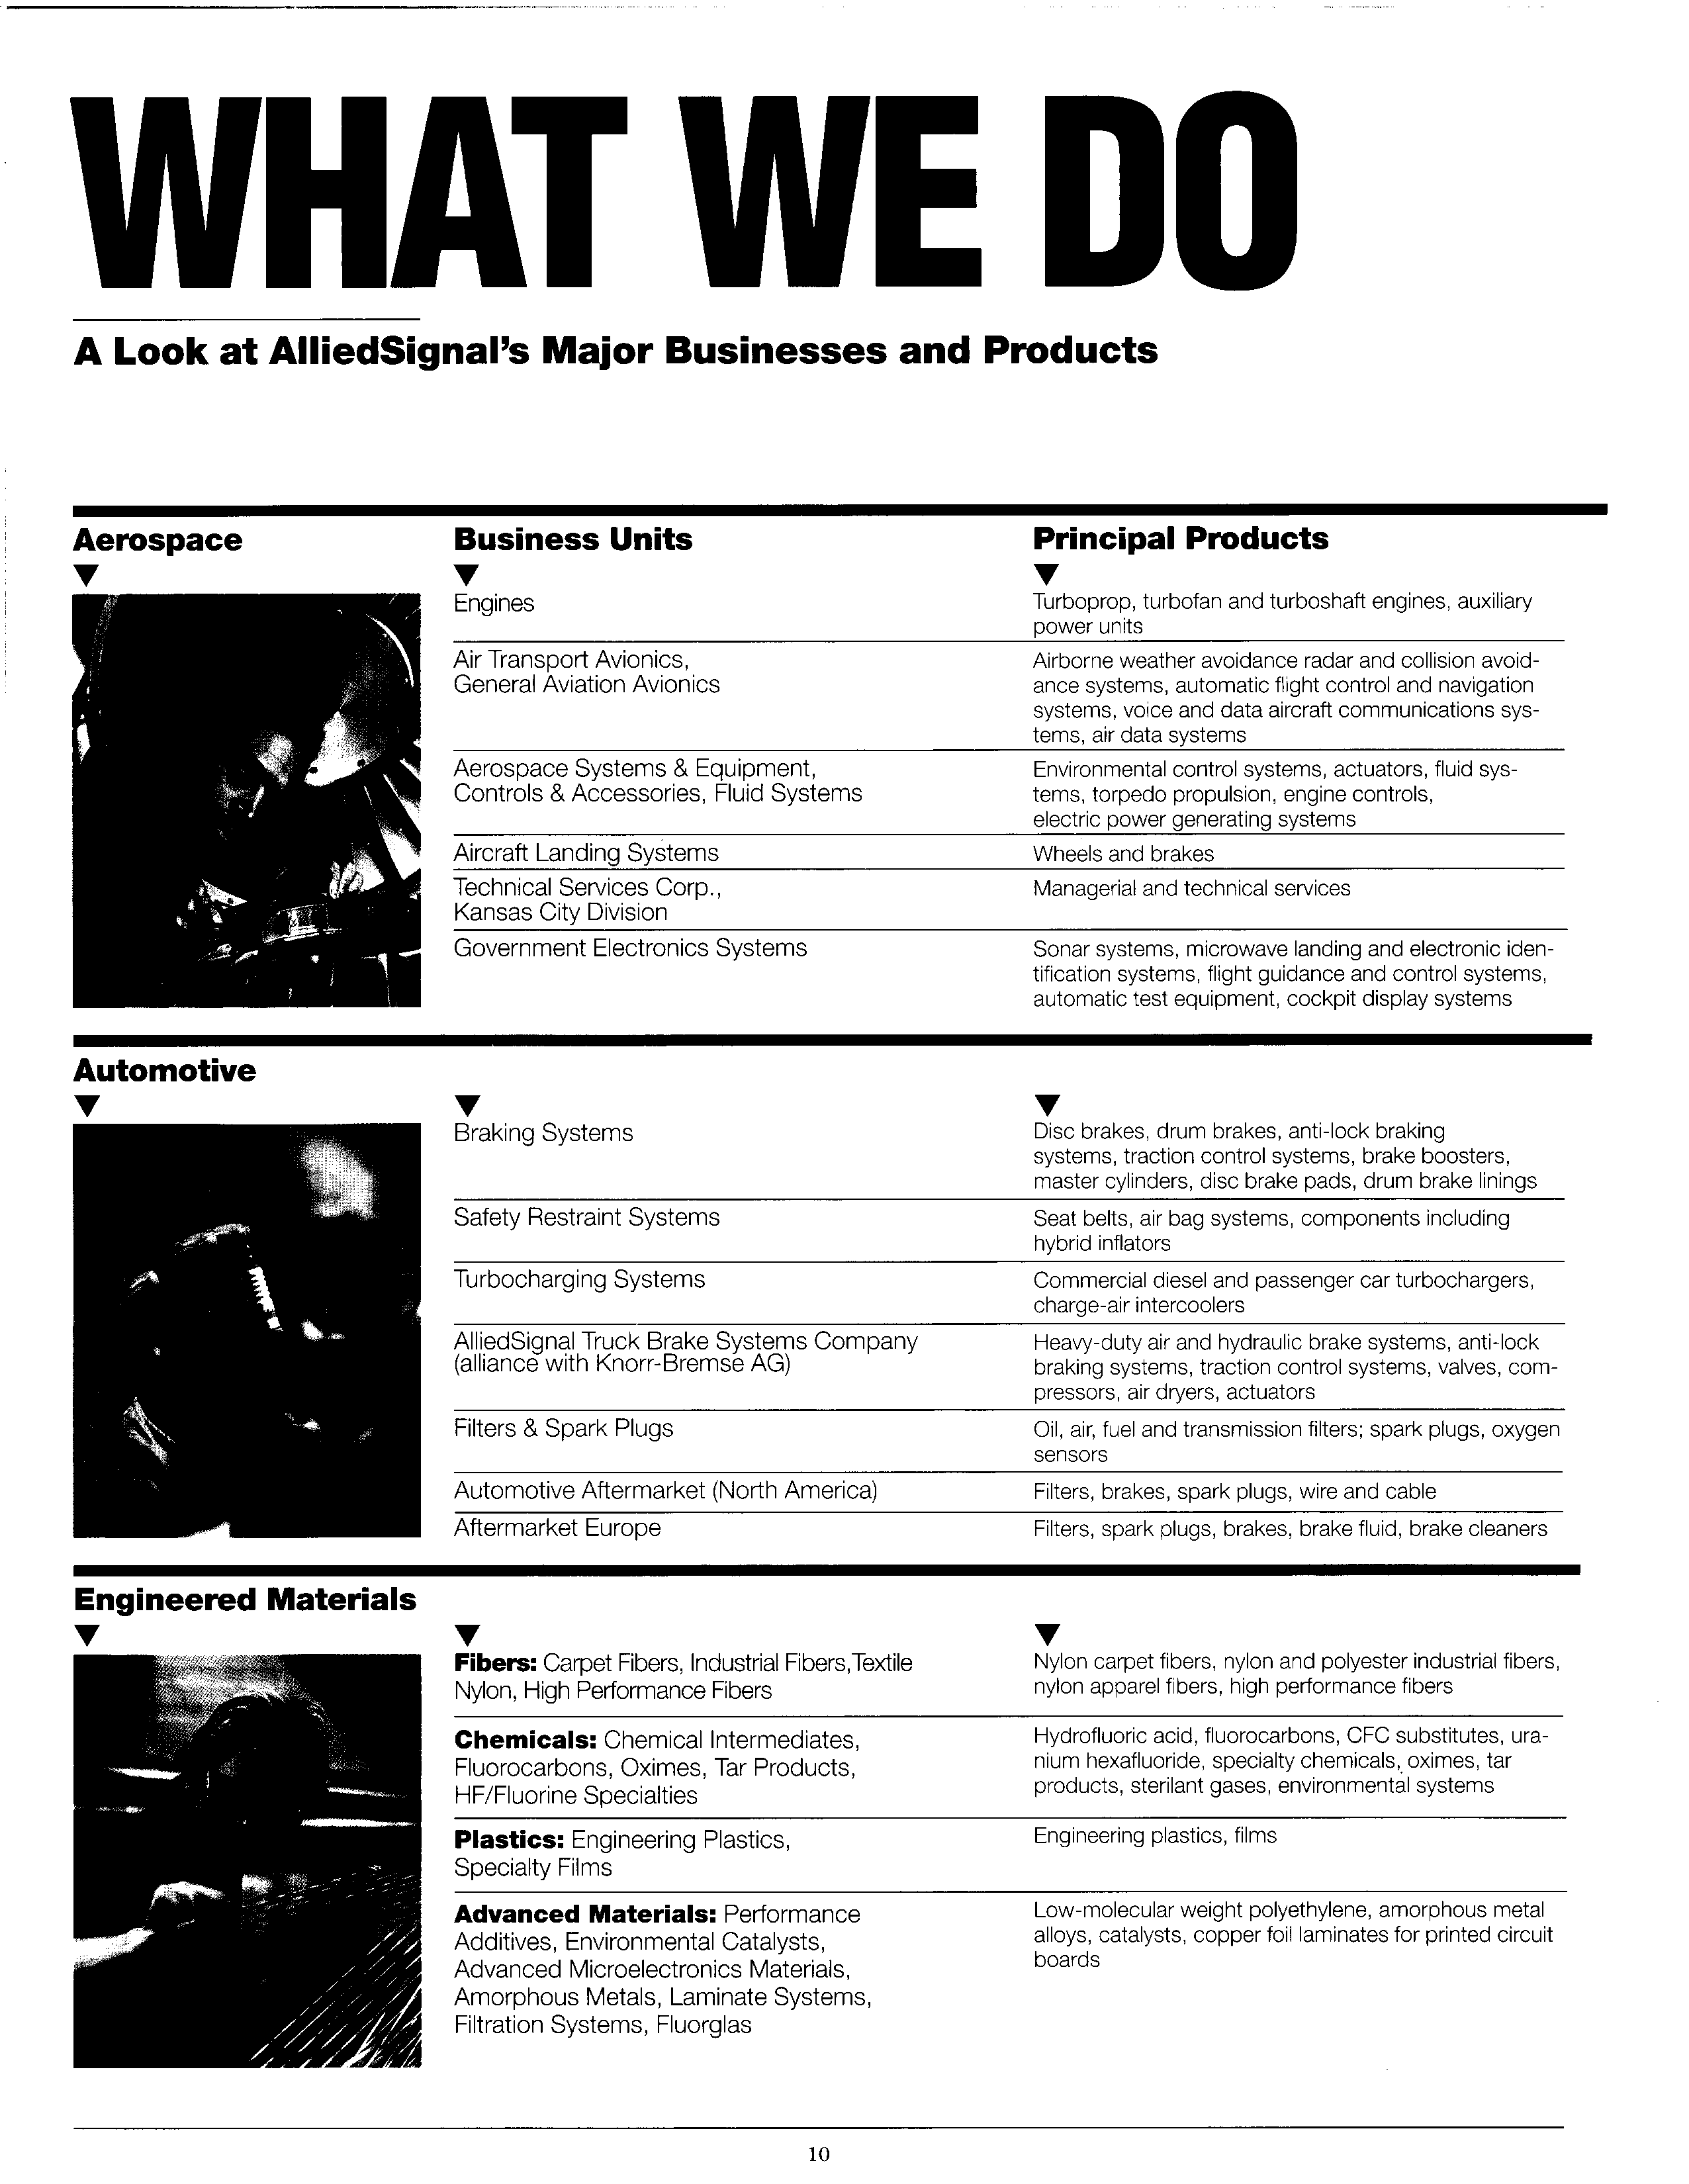

2 C:/1.Quyen_all/Git_quyentn/Quyen_learning_repository/rep.3B/0/9500_023.3B.tif --------------------------------------------------


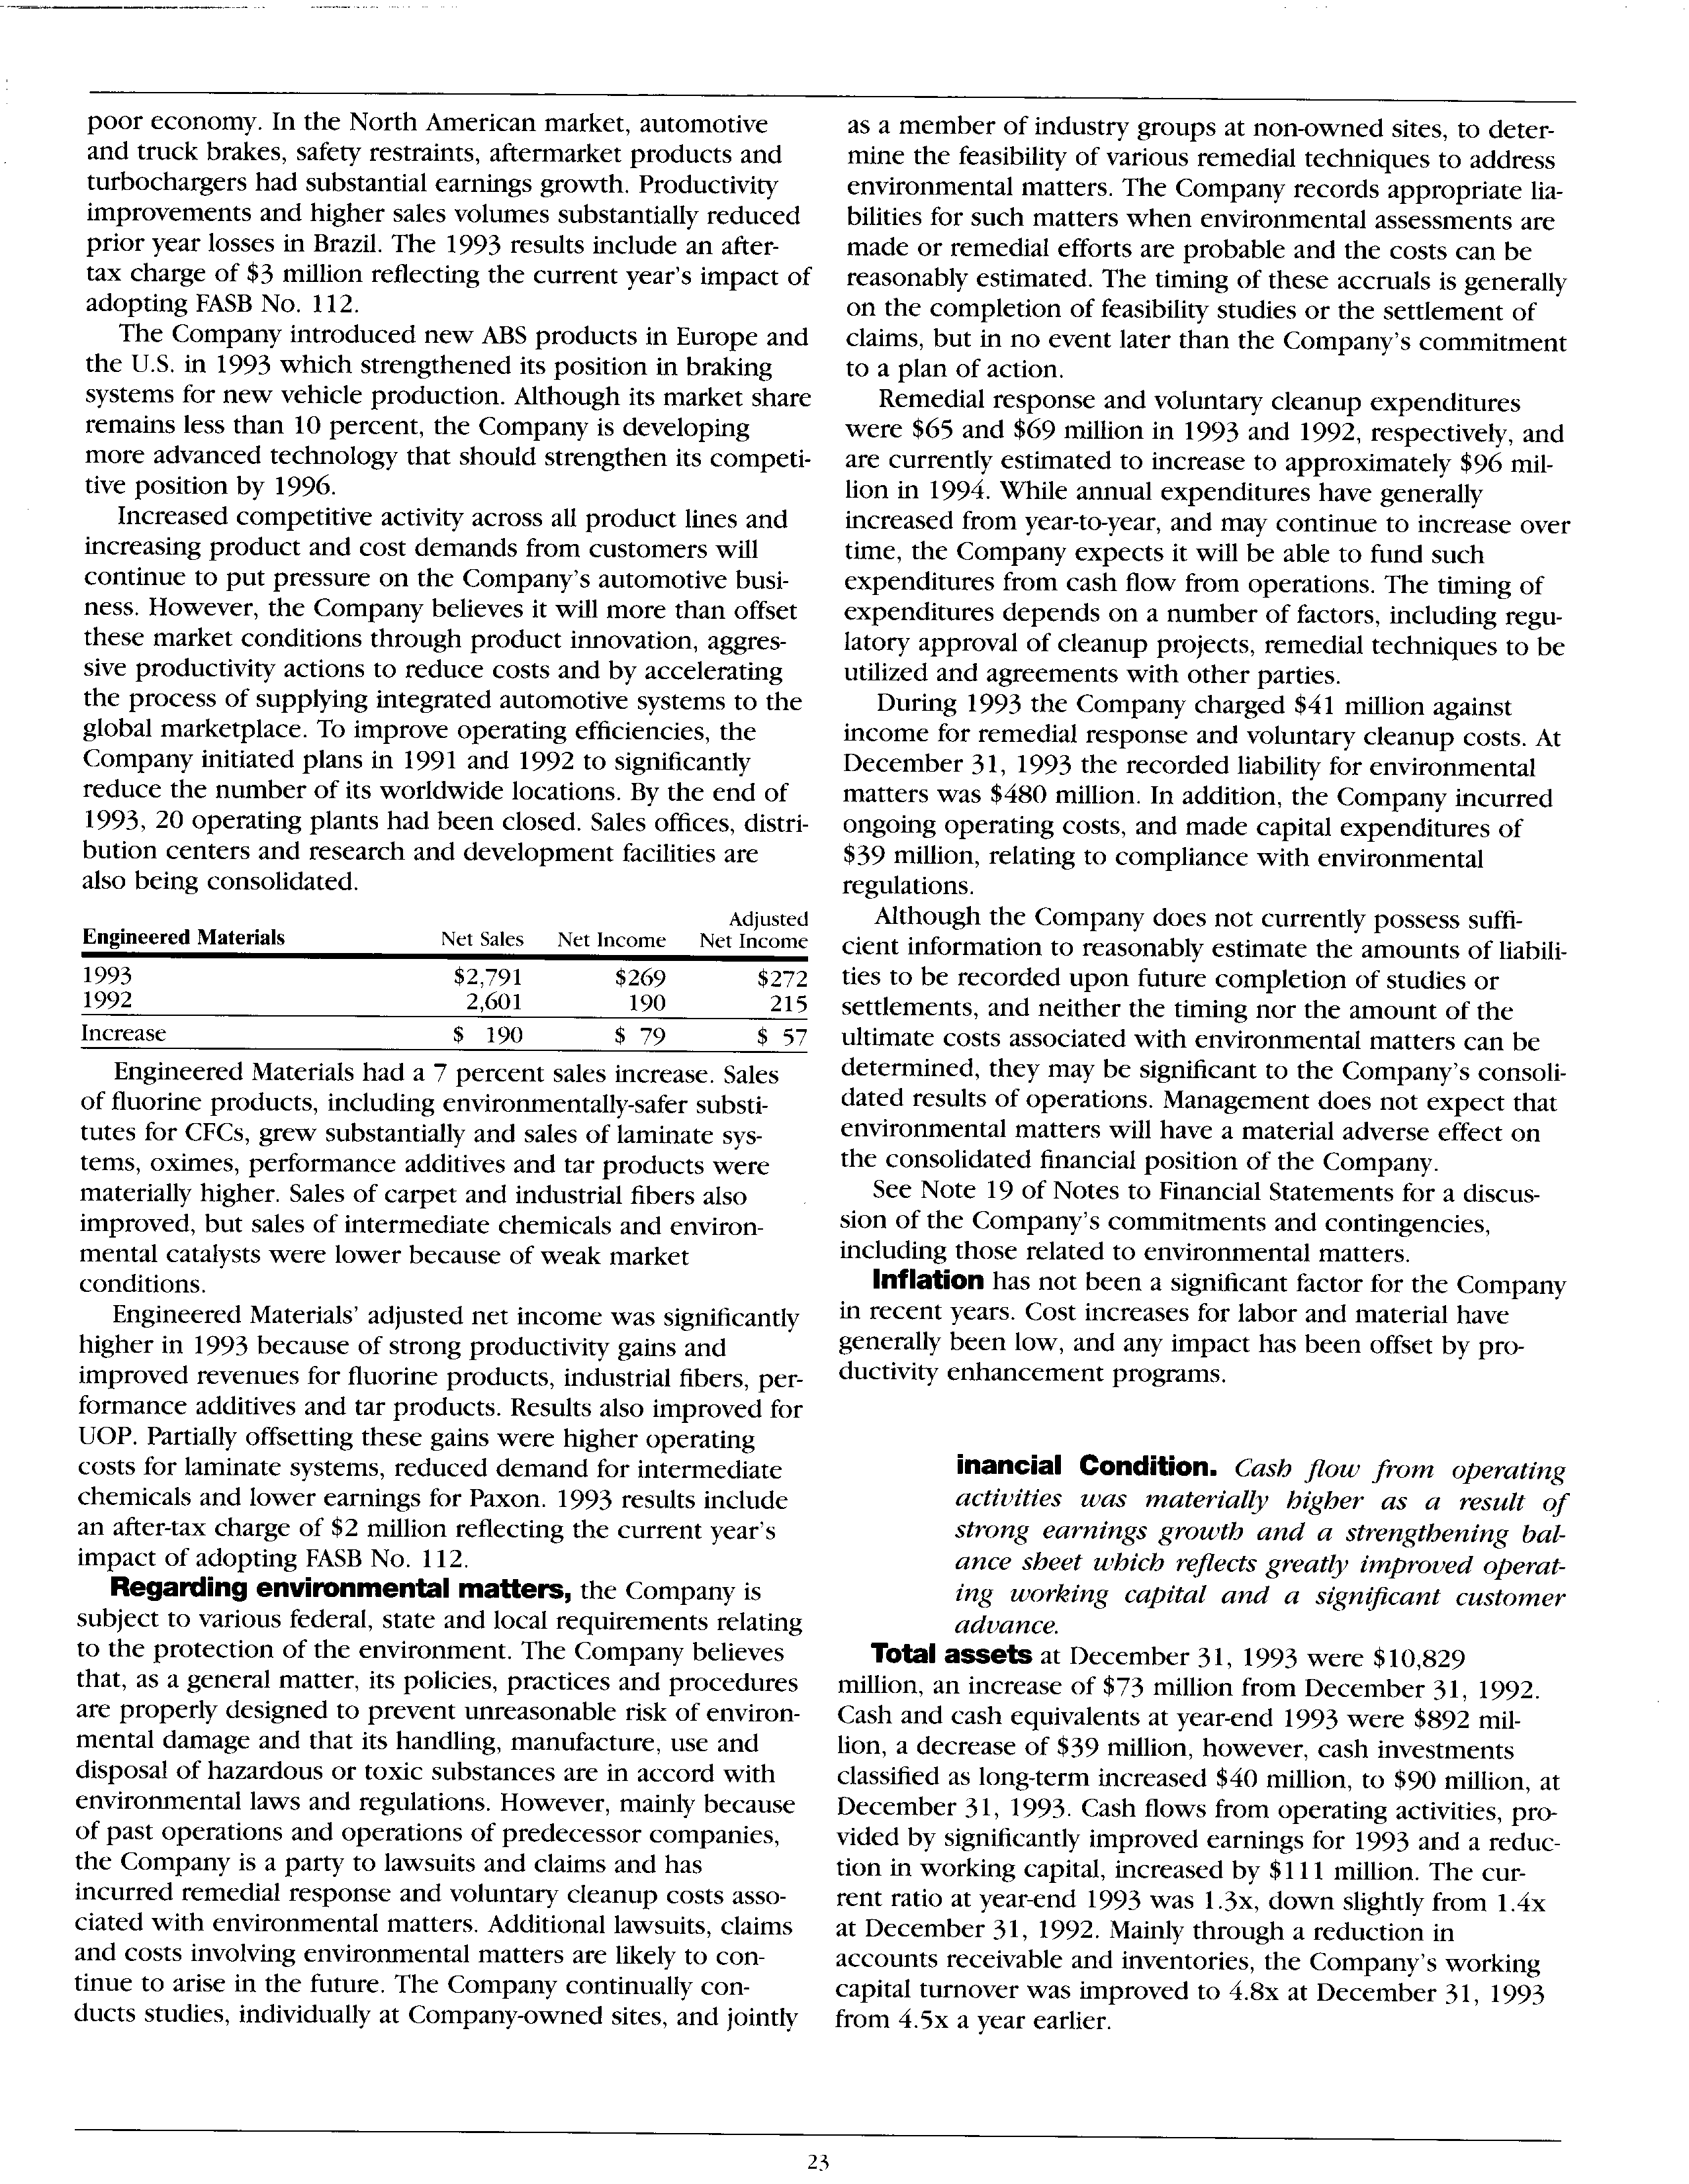

In [44]:
for i in range(1,3):
    print(i,picture_files[i],'-'*50)
    display_image(picture_files[i])

#### 3.3. Convert pictures to text

In [51]:
print(pytesseract.get_tesseract_version())
#print("Below is the main options for Tesseract OCR")
#!tesseract --help-extra

5.0.0-alpha.20200328


In [56]:
start = time.time()
text = ''
tess_text = ''
for i in range(len(picture_files)):
    one_text = get_text_file(text_files[i])
    text += (' '+one_text)
    try:
        one_tess = tesseract_text(picture_files[i])
        tess_text += (' '+one_tess)
    except:
        print(i, picture_files[i]) #get picture file that Tesseract couldn't convert to text
secs = time.time() - start
print('Took: %d minutes %02.f seconds' %(secs//60,secs%60))

Took: 19 minutes 56 seconds


### 4. Assess OCR Tesseract Quality with Cosine Similarity Score

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
docs = [text,tess_text]
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
sim = cosine_similarity(tfidf_matrix[0],tfidf_matrix[1]) #compare 1st doc vs 2nd doc
print('Cosine Similarity: {:.04f}%'.format(sim[0][0]*100))

Cosine Similarity: 99.9634%


In [58]:
print('Number of words from text files:    {:,}'.format(len(re.findall(r'\w+',text))))
print('Number of words from picture files: {:,}'.format(len(re.findall(r'\w+',tess_text))))

Number of words from text files:    144,748
Number of words from picture files: 145,373


### 5. Bonus content

Convert scanned pdf file to text:
- Step 1: Convert each page to an image (extensions of png or jpg)
- Step 2: Convert image to text
- Step 3: Concatenate text from all pages together
- Step 4: Remove all extra image files created in Step 1

#### Option 1: Use Wand to convert PDF pages to pictures

In [60]:
import wand
import io
def scanned_pdf_to_text (file_path, resolution = 300): #Resolution of 300 DPI or higher is the best OCR practice
    scr_pdf = PyPDF2.PdfFileReader(file_path,'rb')
    number_of_pages = src_pdf.getNumPages()
    whole_text = ''
    for i in range(number_of_pages):
        dst_pdf = PyPDF2.PdfFileWriter()
        dst_pdf.addPage(scr_pdf.getPage(i))
        pdf_bytes = io.BytesIO()
        dst_pdf.write(pdf_bytes)
        pdf_bytes.seek(0)
        img = wand.image.Image(file = pdf_bytes, resolution = resolution)
        img.convert('jpg')
        save_file = file_path[:-3]+'jpg'
        img.save(filename = save_file) #overwrite output file for each page
        img = Image.open(save_file)
        text = pytesseract.image_to_string(img,lang='eng')
        whole_text += ('\n'+ text)
    os.remove(save_file) #remove output jpg picture when the last page is written to text
    return whole_text

#### Option 2: Use pdftoppm built-in function in Ubuntu

In [61]:
def pdf_pages_to_text(file_path, resolution = 300):
    subprocess.check_output("pdftoppm -r " +str(resolution)+ " " + repr(file_path) + " " +repr(file_path[:-4]) + " -gray -jpeg",shell=True)
    scr_pdf = PyPDF2.PdfFileReader(file_path,'rb')
    try:
        number_of_pages = src_pdf.getNumPages()
    except:
        number_of_pages = int(subprocess.check_output("pdfinfo "+repr(file_path)+" | grep -oP '(?<=Pages:)[A-Za-z0-9]*';",shell=True))
    len_page = len(str(number_of_pages))
    whole_text = ''
    for i in range(number_of_pages):
        img_file = file_path[:-4] + ("-%0"+str(len_page)+"d") %(i+1) +'.jpg'
        img = Img.open(img_file)
        text = pytesseract.image_to_string(img,lang='eng')
        whole_text += ('\n'+ text)
        os.remove(img_file)
    return whole_text